In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    StratifiedGroupKFold,
    GroupKFold,
    StratifiedKFold,
)

In [49]:
df = pd.read_csv('../Data/merged_cleaned.csv',
                 index_col= [0],
                 parse_dates= [0])



In [50]:
df_feat_1 = df[['Gesamt (Netzlast) [MWh] Berechnete Auflösungen','Deutschland/Luxemburg [€/MWh] Originalauflösungen',
                'hour_sin','dayofweek_sin','month_sin','dayofyear_sin']]
df_load = df_feat_1.iloc[:, [0]]

Train test split

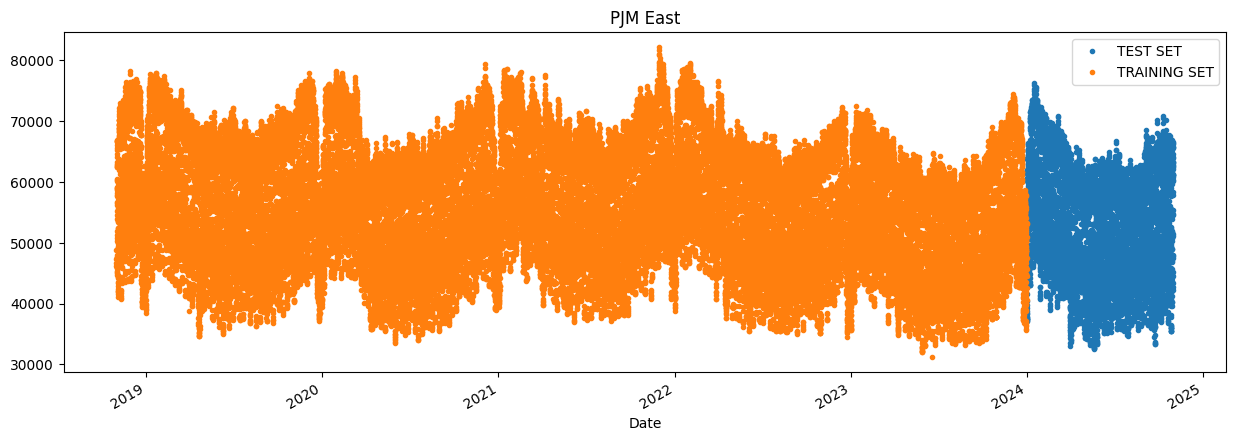

In [51]:
split_date = '01.01.2024'
train = df_load.loc[df_load.index <= split_date].copy()
test = df_load.loc[df_load.index > split_date].copy()

# Plot train and test so you can see where we have split
test \
    .rename(columns={'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'TEST SET'}) \
    .join(train.rename(columns={'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'TRAINING SET'}), 
          how='outer', lsuffix='_test', rsuffix='_train') \
    .plot(figsize=(15, 5), title='PJM East', style='.')
plt.show()


## Simple Prohphet model

In [52]:
train_prophet = train.reset_index() \
    .rename(columns= {'Date':'ds',
                      'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'y'})

In [53]:
%%time
model = Prophet()
model.fit(train_prophet)

14:35:28 - cmdstanpy - INFO - Chain [1] start processing
14:35:41 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 625 ms
Wall time: 14.3 s


In [54]:
test_prophet = test.reset_index() \
    .rename(columns= {'Date':'ds',
                      'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'y'})

test_forecast = model.predict(test_prophet)

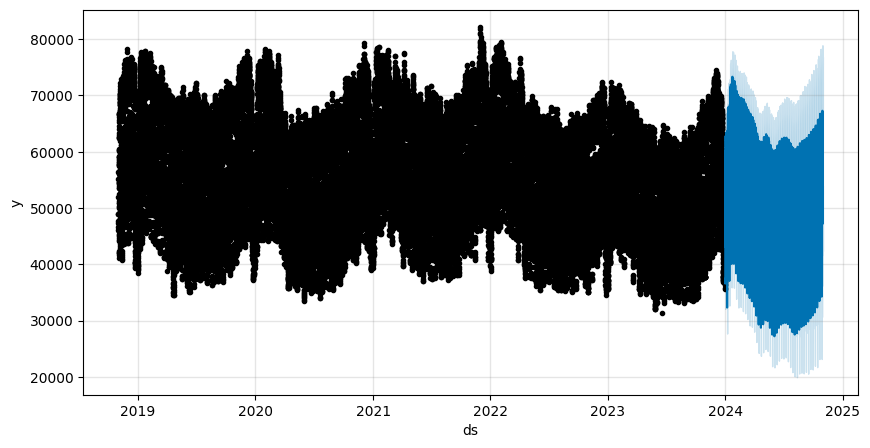

In [55]:
fig, ax = plt.subplots(figsize=(10,5))
fig = model.plot(test_forecast, ax=ax)

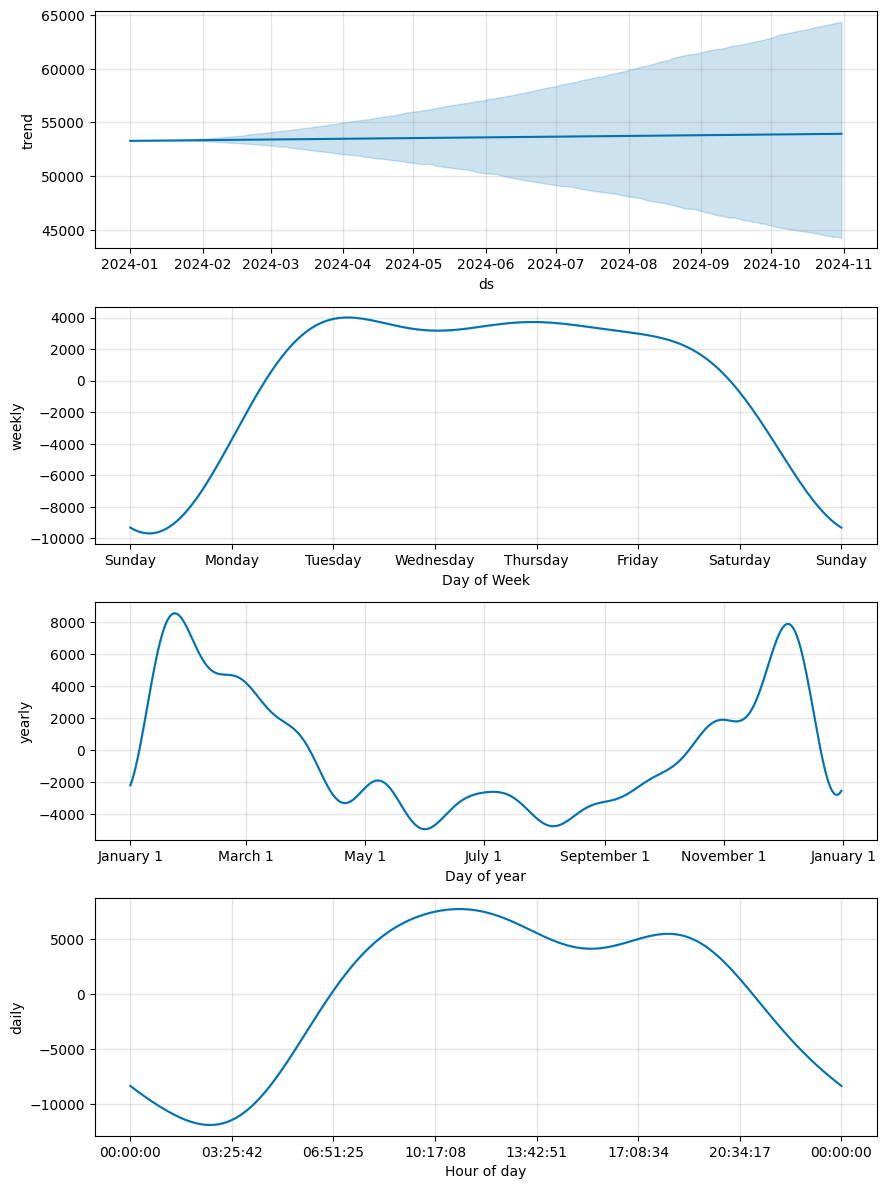

In [56]:
fig = model.plot_components(test_forecast)
plt.show()

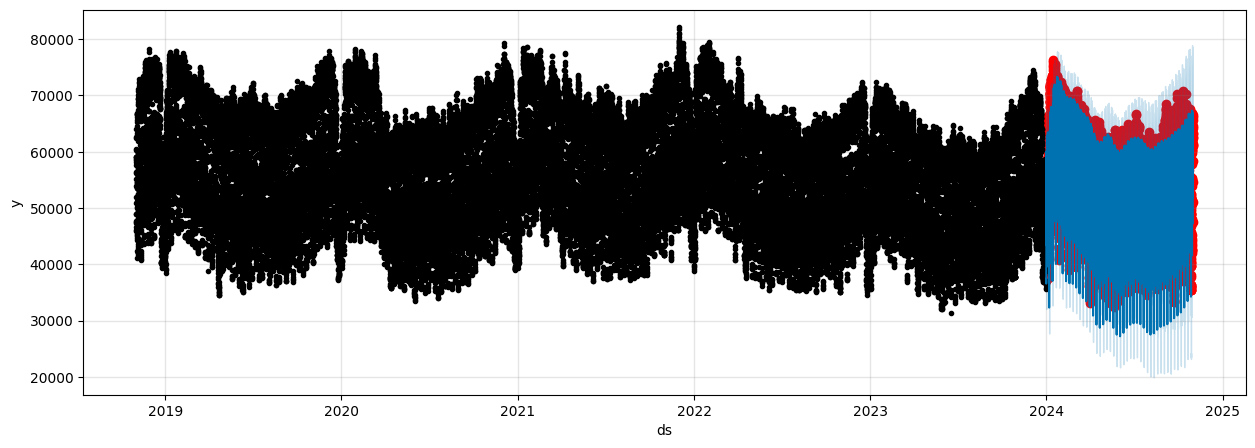

In [57]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['Gesamt (Netzlast) [MWh] Berechnete Auflösungen'], color='r')
fig = model.plot(test_forecast, ax=ax)

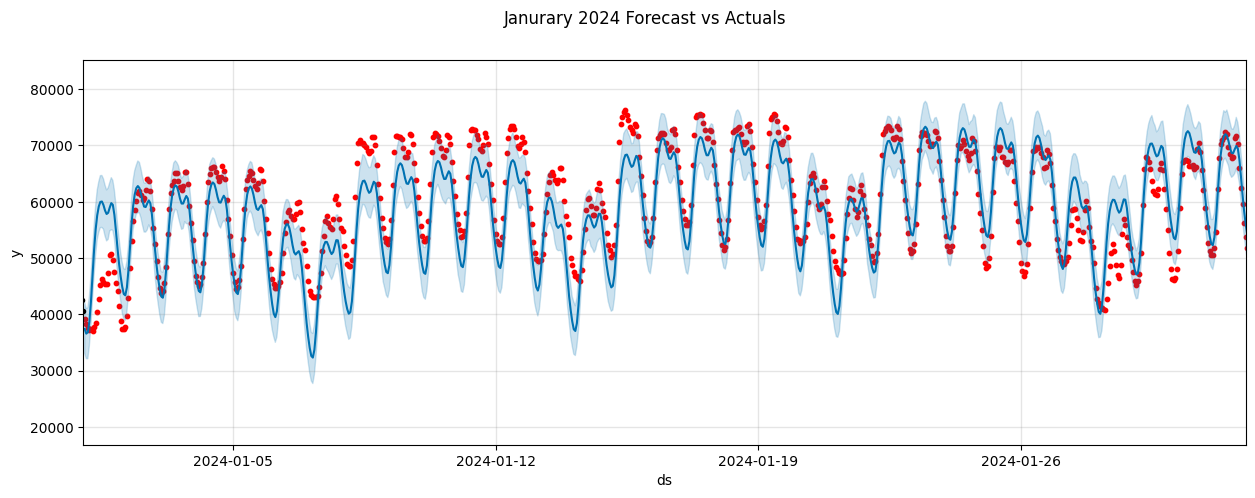

In [58]:
# Filter test data for February 2023
test_february = test.loc['2024-01-01':'2024-02-01']

# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))

# Scatter plot for actuals (February 2023 only)
ax.scatter(test_february.index, test_february['Gesamt (Netzlast) [MWh] Berechnete Auflösungen'], color='r', s=10)

# Plot the forecast (ensure test_forecast contains the relevant forecast for February)
fig = model.plot(test_forecast, ax=ax)

# Set the x-axis limits to February 2023
ax.set_xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2024-02-01'))

# Title of the plot
plt.suptitle('Janurary 2024 Forecast vs Actuals')

# Show the plot
plt.show()


In [59]:
mean_absolute_percentage_error(y_true = test['Gesamt (Netzlast) [MWh] Berechnete Auflösungen'], y_pred = test_forecast['yhat'])

0.05331961060461722

In [60]:
df_load = df[['Gesamt (Netzlast) [MWh] Berechnete Auflösungen','Holiday']]
split_date = '01.01.2024'
train = df_load.loc[df_load.index <= split_date].copy()
test = df_load.loc[df_load.index > split_date].copy()


In [61]:
train_prophet = train.reset_index() \
    .rename(columns= {'Holiday':'holiday',
                      'Date':'ds',
                      'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'y'})

In [62]:
train_prophet.head()

,ds,y,holiday
0,2018-11-01 00:00:00,48879.50,Not a Holiday
1,2018-11-01 01:00:00,47312.50,Not a Holiday
2,2018-11-01 02:00:00,46093.75,Not a Holiday
3,2018-11-01 03:00:00,46710.50,Not a Holiday
4,2018-11-01 04:00:00,47624.25,Not a Holiday


In [63]:
holiday = train_prophet.iloc[:, [0, 2]]


In [64]:

train_prophet = train_prophet.iloc[:,0:2]


In [77]:
holiday[holiday['ds']=='2019-12-25 00:00:00']

,ds,holiday
10062,2019-12-25,Christmas Day


In [66]:
%%time
model = Prophet(holidays=holiday)
model.fit(train_prophet)

14:35:46 - cmdstanpy - INFO - Chain [1] start processing
14:36:08 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 1.17 s
Wall time: 25.5 s


In [67]:
test_forecast = model.predict(test_prophet)

In [68]:
mean_absolute_percentage_error(y_true = test['Gesamt (Netzlast) [MWh] Berechnete Auflösungen'], y_pred = test_forecast['yhat'])

0.15536551454856928